# KG Normalization Analysis

Analysis of LLM normalization results from the KG experiment pipeline.
Data exported from `kg_experiment_v2.ipynb`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
df_llm = pd.read_csv(Path("llm_normalization_results_levenshtein.csv"))
threshold = 0.45  # similarity threshold used during pipeline run
print(f"Loaded {len(df_llm)} LLM check results")
print(f"  Merges: {df_llm['should_merge'].sum()}, Non-merges: {(~df_llm['should_merge']).sum()}")
print(f"  Similarity range: {df_llm['similarity'].min():.3f} - {df_llm['similarity'].max():.3f}")

Loaded 454 LLM check results
  Merges: 26, Non-merges: 428
  Similarity range: 0.455 - 0.923


In [4]:
# Per-paragraph stats: how LLM checks grow as master graph grows
para_stats = df_llm.groupby("paragraph_idx").agg(
    llm_checks=("should_merge", "count"),
    merges=("should_merge", "sum"),
    min_sim=("similarity", "min"),
    max_sim=("similarity", "max"),
    mean_sim=("similarity", "mean"),
)
para_stats["merges"] = para_stats["merges"].astype(int)
print("LLM checks per paragraph (shows scaling as graph grows):")
print(para_stats.to_string())

print(f"\n--- Threshold analysis ---")
print(f"Current threshold: {threshold}")
merges = df_llm[df_llm["should_merge"]]
non_merges = df_llm[~df_llm["should_merge"]]
print(f"Total: {len(df_llm)} checks ({len(merges)} merges, {len(non_merges)} non-merges)")

if not merges.empty:
    print(f"\nMerge similarities:    min={merges['similarity'].min():.3f}, max={merges['similarity'].max():.3f}, mean={merges['similarity'].mean():.3f}")
print(f"Non-merge similarities: min={non_merges['similarity'].min():.3f}, max={non_merges['similarity'].max():.3f}, mean={non_merges['similarity'].mean():.3f}")

print(f"\nThreshold sweep \u2014 checks remaining (merges kept):")
for t in [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]:
    above = df_llm[df_llm["similarity"] >= t]
    merges_kept = above["should_merge"].sum()
    total_merges = merges["should_merge"].sum() if not merges.empty else 0
    pct = len(above) / len(df_llm) * 100
    print(f"  {t:.2f}: {len(above):3d} checks ({pct:4.0f}%), {int(merges_kept)}/{int(total_merges)} merges kept")

LLM checks per paragraph (shows scaling as graph grows):
               llm_checks  merges   min_sim   max_sim  mean_sim
paragraph_idx                                                  
3                       2       0  0.500000  0.666667  0.583333
4                       1       0  0.555556  0.555556  0.555556
6                       2       1  0.625000  0.888889  0.756944
7                       7       0  0.473684  0.666667  0.530254
9                       8       0  0.470588  0.666667  0.540157
11                      3       0  0.500000  0.600000  0.533333
13                      7       1  0.500000  0.666667  0.556122
15                      2       1  0.529412  0.636364  0.582888
16                      1       0  0.500000  0.500000  0.500000
18                      2       1  0.600000  0.833333  0.716667
19                      3       0  0.500000  0.533333  0.511111
20                      1       0  0.461538  0.461538  0.461538
21                      6       0  0.454545  0.

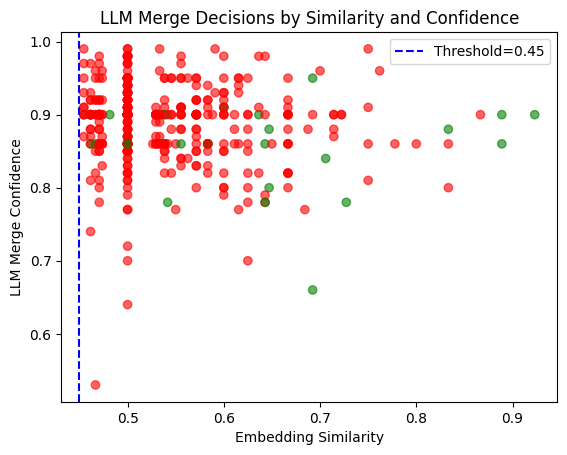

In [5]:
plt.scatter(df_llm["similarity"], df_llm["confidence"], c=df_llm["should_merge"].map({True: "green", False: "red"}), alpha=0.6)
plt.xlabel("Embedding Similarity")
plt.ylabel("LLM Merge Confidence")
plt.title("LLM Merge Decisions by Similarity and Confidence")
plt.axvline(threshold, color="blue", linestyle="--", label=f"Threshold={threshold}")
plt.legend()
plt.show()

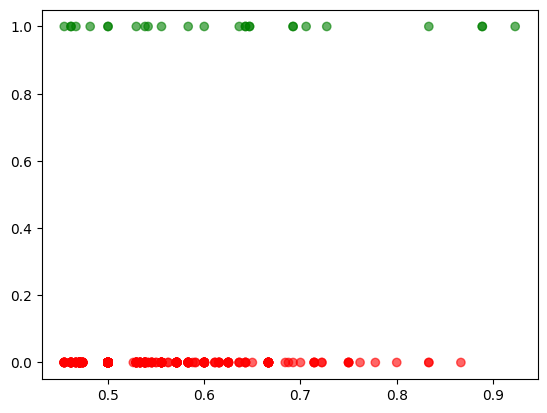

In [6]:
plt.scatter(df_llm["similarity"], df_llm["should_merge"].map({True: 1, False: 0}), c=df_llm["should_merge"].map({True: "green", False: "red"}), alpha=0.6)

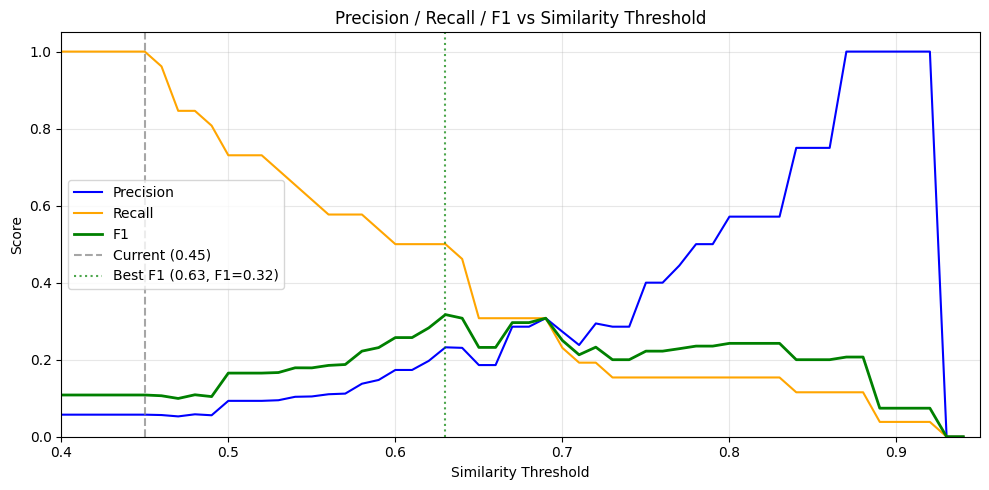

In [9]:
# Precision, Recall, F1 vs similarity threshold
# Treating LLM should_merge as ground truth:
#   At threshold t: candidates = pairs with similarity >= t
#   TP = merges above t, FP = non-merges above t, FN = merges below t

thresholds = np.arange(threshold-0.05, 0.95, 0.01)
precision, recall, f1 = [], [], []

total_merges = df_llm["should_merge"].sum()

for t in thresholds:
    above = df_llm[df_llm["similarity"] >= t]
    tp = above["should_merge"].sum()
    fp = len(above) - tp
    fn = total_merges - tp

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0

    precision.append(p)
    recall.append(r)
    f1.append(f)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, precision, label="Precision", color="blue")
ax.plot(thresholds, recall, label="Recall", color="orange")
ax.plot(thresholds, f1, label="F1", color="green", linewidth=2)
ax.axvline(threshold, color="gray", linestyle="--", alpha=0.7, label=f"Current ({threshold})")

best_idx = np.argmax(f1)
ax.axvline(thresholds[best_idx], color="green", linestyle=":", alpha=0.7,
           label=f"Best F1 ({thresholds[best_idx]:.2f}, F1={f1[best_idx]:.2f})")

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Score")
ax.set_title("Precision / Recall / F1 vs Similarity Threshold")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(threshold-0.05, 0.95)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

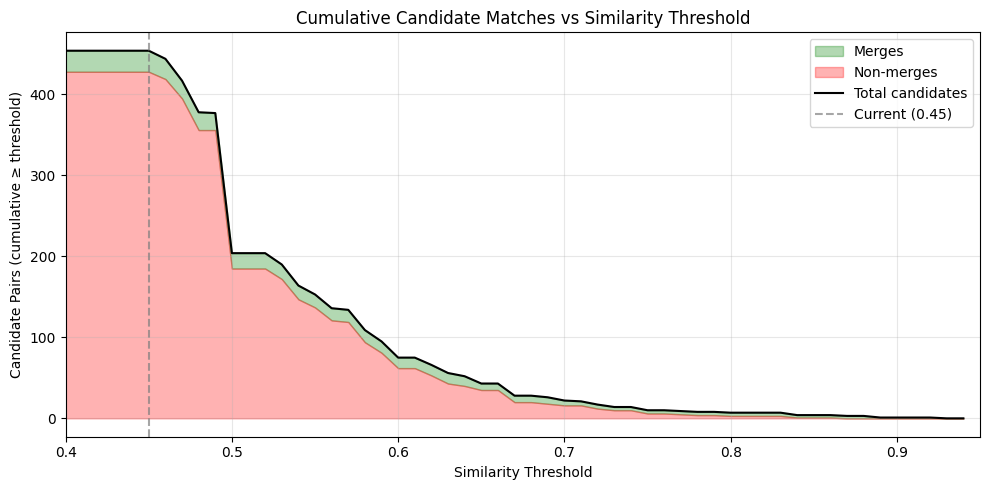

In [10]:
# Cumulative count of potential matches vs similarity threshold
# At each threshold: how many candidate pairs have similarity >= t

thresholds_cum = np.arange(threshold-0.05, 0.95, 0.01)
counts_all = [len(df_llm[df_llm["similarity"] >= t]) for t in thresholds_cum]
counts_merge = [df_llm.loc[df_llm["similarity"] >= t, "should_merge"].sum() for t in thresholds_cum]
counts_no_merge = [c - m for c, m in zip(counts_all, counts_merge)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.fill_between(thresholds_cum, counts_no_merge, counts_all, alpha=0.3, color="green", label="Merges")
ax.fill_between(thresholds_cum, 0, counts_no_merge, alpha=0.3, color="red", label="Non-merges")
ax.plot(thresholds_cum, counts_all, color="black", linewidth=1.5, label="Total candidates")
ax.axvline(threshold, color="gray", linestyle="--", alpha=0.7, label=f"Current ({threshold})")

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Candidate Pairs (cumulative \u2265 threshold)")
ax.set_title("Cumulative Candidate Matches vs Similarity Threshold")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(threshold-0.05, 0.95)
plt.tight_layout()
plt.show()

In [14]:
len(df_llm)

454

In [11]:
df_llm["should_merge"].sum()

np.int64(26)

In [12]:
df_llm[df_llm["should_merge"]==True].sort_values("similarity", ascending=False)

,paragraph_idx,page,entity1_name,entity2_name,similarity,should_merge,confidence,reasoning
83,29,330,Carthaginian,Carthaginians,0.923077,True,0.90,Both entities refer to the collective people o...
3,6,321,Etruscan,Etruscans,0.888889,True,0.90,Both entries clearly refer to the same histori...
94,30,330,governors,governor,0.888889,True,0.86,Entity 1 is a collective label ('governors') r...
33,18,326,Roman,Romans,0.833333,True,0.88,Both entries refer to the same collective peop...
393,74,354,res publica,Roman Republic,0.727273,True,0.78,The Latin term 'res publica' literally means '...
116,33,332,Hellenistic East,Hellenistic world,0.705882,True,0.84,Both names refer to the same broad Hellenistic...
95,30,330,new provinces,Roman provinces,0.692308,True,0.66,"Entity 1 (""new provinces"") is a generic phrase..."
208,46,340,the Rubicon,Rubicon,0.692308,True,0.95,Both entries clearly refer to the same geograp...
329,66,348,Greek background,Greek influence,0.647059,True,0.88,Both mentions describe the same cultural pheno...
53,23,327,Greek cities,Greek city-states,0.647059,True,0.80,The two mentions refer to the same general con...


In [13]:
df_llm[df_llm["should_merge"]==False].sample(20, random_state=42).sort_values("similarity", ascending=False)

,paragraph_idx,page,entity1_name,entity2_name,similarity,should_merge,confidence,reasoning
34,18,326,Romans,Rome,0.600000,False,0.93,These two refer to closely connected concepts ...
80,28,329,western Tunisia,Western Sicily,0.600000,False,0.90,The two entities are different geographic regi...
189,41,337,pirates,magistrates,0.545455,False,0.82,The two entities refer to different collective...
164,39,336,Social War,special court,0.538462,False,0.86,The two entities refer to different things: on...
152,37,334,Roman legions,Pax Romana,0.538462,False,0.86,"These refer to different kinds of entities. ""R..."
371,69,350,proletarii (Roman proletariat),Pax Romana,0.529412,False,0.89,These are different kinds of entities: the pro...
167,39,336,Roman businessmen,Roman Mediterranean,0.526316,False,0.86,The first entity is a group of people (Roman b...
435,79,356,Roman pantheon,Roman thinkers,0.500000,False,0.92,The Roman pantheon is a collection of gods and...
442,80,356,Tyana,Trajan,0.500000,False,0.86,Tyana is a city; Trajan is a Roman emperor (pe...
10,7,321,Europe,Rome,0.500000,False,0.86,The two entities are different: one is the con...
